# XGBoost Model for Residual Sales Prediction

In [1]:
# Imports
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

pd.options.mode.copy_on_write = True


## 1. Data Loading and Initial Exploration

In [2]:
# Load the retail data
df = pd.read_csv('retail.csv')

# Display basic information about the dataset
print("Dataset shape:", df.shape)
df.head()


Dataset shape: (73100, 15)


,Date,Store ID,Product ID,Category,Region,Inventory Level,Units Sold,Units Ordered,Demand Forecast,Price,Discount,Weather Condition,Holiday/Promotion,Competitor Pricing,Seasonality
0,2022-01-01,S001,P0001,Groceries,North,231,127,55,135.47,33.50,20,Rainy,0,29.69,Autumn
1,2022-01-01,S001,P0002,Toys,South,204,150,66,144.04,63.01,20,Sunny,0,66.16,Autumn
2,2022-01-01,S001,P0003,Toys,West,102,65,51,74.02,27.99,10,Sunny,1,31.32,Summer
3,2022-01-01,S001,P0004,Toys,North,469,61,164,62.18,32.72,10,Cloudy,1,34.74,Autumn
4,2022-01-01,S001,P0005,Electronics,East,166,14,135,9.26,73.64,0,Sunny,0,68.95,Summer


In [3]:

# Check data types and missing values
df.info()
df.isnull().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73100 entries, 0 to 73099
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Date                73100 non-null  object 
 1   Store ID            73100 non-null  object 
 2   Product ID          73100 non-null  object 
 3   Category            73100 non-null  object 
 4   Region              73100 non-null  object 
 5   Inventory Level     73100 non-null  int64  
 6   Units Sold          73100 non-null  int64  
 7   Units Ordered       73100 non-null  int64  
 8   Demand Forecast     73100 non-null  float64
 9   Price               73100 non-null  float64
 10  Discount            73100 non-null  int64  
 11  Weather Condition   73100 non-null  object 
 12  Holiday/Promotion   73100 non-null  int64  
 13  Competitor Pricing  73100 non-null  float64
 14  Seasonality         73100 non-null  object 
dtypes: float64(3), int64(5), object(7)
memory usage: 8.4+

Date                  0
Store ID              0
Product ID            0
Category              0
Region                0
Inventory Level       0
Units Sold            0
Units Ordered         0
Demand Forecast       0
Price                 0
Discount              0
Weather Condition     0
Holiday/Promotion     0
Competitor Pricing    0
Seasonality           0
dtype: int64


## 2. Feature Engineering

In [4]:
# Convert date to datetime format
df['Date'] = pd.to_datetime(df['Date'])

In [5]:
print(type(df['Date'][0]))

<class 'pandas._libs.tslibs.timestamps.Timestamp'>


In [6]:
# Calculate the residual (Units Sold - Demand Forecast)
df['Residual_Sales'] = df['Units Sold'] - df['Demand Forecast']
df.head()

,Date,Store ID,Product ID,Category,Region,Inventory Level,Units Sold,Units Ordered,Demand Forecast,Price,Discount,Weather Condition,Holiday/Promotion,Competitor Pricing,Seasonality,Residual_Sales
0,2022-01-01,S001,P0001,Groceries,North,231,127,55,135.47,33.50,20,Rainy,0,29.69,Autumn,-8.47
1,2022-01-01,S001,P0002,Toys,South,204,150,66,144.04,63.01,20,Sunny,0,66.16,Autumn,5.96
2,2022-01-01,S001,P0003,Toys,West,102,65,51,74.02,27.99,10,Sunny,1,31.32,Summer,-9.02
3,2022-01-01,S001,P0004,Toys,North,469,61,164,62.18,32.72,10,Cloudy,1,34.74,Autumn,-1.18
4,2022-01-01,S001,P0005,Electronics,East,166,14,135,9.26,73.64,0,Sunny,0,68.95,Summer,4.74


In [7]:
# Select for store 1, drop unecessary columns
df.drop(columns=['Product ID', 'Category', 'Weather Condition', 'Competitor Pricing', 'Seasonality'], inplace=True)

In [8]:
# Show head of new df
df.head()

,Date,Store ID,Region,Inventory Level,Units Sold,Units Ordered,Demand Forecast,Price,Discount,Holiday/Promotion,Residual_Sales
0,2022-01-01,S001,North,231,127,55,135.47,33.50,20,0,-8.47
1,2022-01-01,S001,South,204,150,66,144.04,63.01,20,0,5.96
2,2022-01-01,S001,West,102,65,51,74.02,27.99,10,1,-9.02
3,2022-01-01,S001,North,469,61,164,62.18,32.72,10,1,-1.18
4,2022-01-01,S001,East,166,14,135,9.26,73.64,0,0,4.74


In [9]:
# filter df for Store 1 and East region
df_new = df[(df['Store ID']=='S001') & (df['Region']=='East')]
df_new.head()

,Date,Store ID,Region,Inventory Level,Units Sold,Units Ordered,Demand Forecast,Price,Discount,Holiday/Promotion,Residual_Sales
4,2022-01-01,S001,East,166,14,135,9.26,73.64,0,0,4.74
6,2022-01-01,S001,East,359,97,167,108.92,34.16,10,1,-11.92
18,2022-01-01,S001,East,352,257,186,267.38,73.28,10,0,-10.38
19,2022-01-01,S001,East,274,99,166,115.23,30.24,5,0,-16.23
103,2022-01-02,S001,East,248,116,107,133.92,49.56,5,0,-17.92


In [10]:
# Now we drop 'Region' and 'Store ID' then groupby date to get appropriate sums
df_new.drop(columns=['Store ID', 'Region'], inplace=True)

df_group = df_new.groupby('Date').mean()
df_group.head()

,Inventory Level,Units Sold,Units Ordered,Demand Forecast,Price,Discount,Holiday/Promotion,Residual_Sales
Date,,,,,,,,
2022-01-01,287.750000,116.750000,163.500000,125.197500,52.830000,6.250000,0.250000,-8.447500
2022-01-02,255.857143,102.000000,103.857143,106.812857,45.644286,7.142857,0.714286,-4.812857
2022-01-03,181.666667,78.166667,98.000000,84.855000,63.966667,5.833333,0.333333,-6.688333
2022-01-04,361.250000,117.750000,143.250000,128.012500,81.002500,16.250000,0.250000,-10.262500
2022-01-05,280.000000,66.600000,146.000000,68.858000,61.566000,9.000000,0.000000,-2.258000


In [11]:
# Get features to help XGBoost with a timeseries prediction
df_group.reset_index(inplace=True)
df_group['Year'] = df_group['Date'].dt.year
df_group['Month'] = df_group['Date'].dt.month
df_group['Day'] = df_group['Date'].dt.day
df_group['DayOfWeek'] = df_group['Date'].dt.dayofweek
df_group.head()

,Date,Inventory Level,Units Sold,Units Ordered,Demand Forecast,Price,Discount,Holiday/Promotion,Residual_Sales,Year,Month,Day,DayOfWeek
0,2022-01-01,287.750000,116.750000,163.500000,125.197500,52.830000,6.250000,0.250000,-8.447500,2022,1,1,5
1,2022-01-02,255.857143,102.000000,103.857143,106.812857,45.644286,7.142857,0.714286,-4.812857,2022,1,2,6
2,2022-01-03,181.666667,78.166667,98.000000,84.855000,63.966667,5.833333,0.333333,-6.688333,2022,1,3,0
3,2022-01-04,361.250000,117.750000,143.250000,128.012500,81.002500,16.250000,0.250000,-10.262500,2022,1,4,1
4,2022-01-05,280.000000,66.600000,146.000000,68.858000,61.566000,9.000000,0.000000,-2.258000,2022,1,5,2


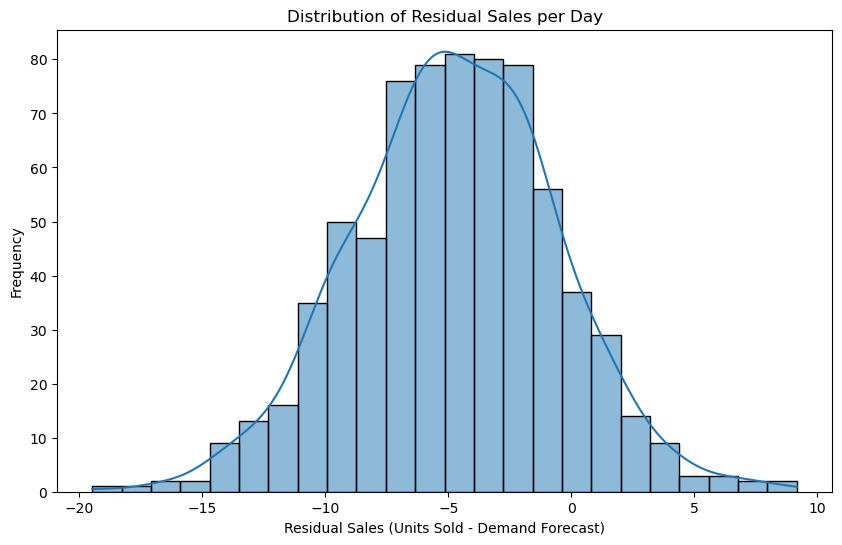

In [12]:
# Display the distribution of residual sales
plt.figure(figsize=(10, 6))
sns.histplot(df_group['Residual_Sales'], kde=True)
plt.title('Distribution of Residual Sales per Day')
plt.xlabel('Residual Sales (Units Sold - Demand Forecast)')
plt.ylabel('Frequency')
plt.show()

## 3. Feature Preparation

In [60]:
df_group.set_index('Date', inplace=True)

In [61]:
# Define features for the model
columns = [
    # Numerical features - take out sales and demand forecast
    'Inventory Level', 
    'Price', 'Discount', 'Holiday/Promotion', 
    'Month', 'Day', 'DayOfWeek'
]

X = df_group[columns]
y = df_group['Residual_Sales']

In [62]:
X

,Inventory Level,Price,Discount,Holiday/Promotion,Month,Day,DayOfWeek
Date,,,,,,,
2022-01-01,287.750000,52.830000,6.250000,0.250000,1,1,5
2022-01-02,255.857143,45.644286,7.142857,0.714286,1,2,6
2022-01-03,181.666667,63.966667,5.833333,0.333333,1,3,0
2022-01-04,361.250000,81.002500,16.250000,0.250000,1,4,1
2022-01-05,280.000000,61.566000,9.000000,0.000000,1,5,2
...,...,...,...,...,...,...,...
2023-12-28,325.500000,56.063333,13.333333,0.333333,12,28,3
2023-12-29,125.000000,55.603333,5.000000,0.333333,12,29,4
2023-12-30,266.000000,79.650000,11.666667,0.333333,12,30,5


In [63]:
# Split by 80% and 20% 
trainin = int(round(0.8*len(X),0))

X_train = X[:trainin]
y_train = y[:trainin]
X_test = X[trainin+1:]
y_test = y[trainin+1:]

# 5. XGBoost Model Training

In [105]:
# Initialize XGBoost regressor - used Claud AI to get the initial parameters
# xgb_model = xgb.XGBRegressor(
#     objective='reg:squarederror',
#     n_estimators=100,
#     max_depth=6,
#     learning_rate=0.1,
#     subsample=0.8,
#     colsample_bytree=0.8,
#     random_state=42
# )
from xgboost import XGBRFRegressor

xgb_model = XGBRFRegressor(
    n_estimators=10,
    max_depth=6,
    learning_rate=3,
    subsample=0.8,
    colsample_bynode=0.8,
    reg_lambda=1.0,
    random_state=42
)


In [106]:
# Train the model
xgb_model.fit(X_train, y_train)


XGBRFRegressor(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bytree=None, device=None,
               early_stopping_rounds=None, enable_categorical=False,
               eval_metric=None, feature_types=None, gamma=None,
               grow_policy=None, importance_type=None,
               interaction_constraints=None, learning_rate=3, max_bin=None,
               max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=6, max_leaves=None,
               min_child_weight=None, missing=nan, monotone_constraints=None,
               multi_strategy=None, n_estimators=10, n_jobs=None,
               num_parallel_tree=None, objective='reg:squarederror',
               random_state=42, ...)

## 6. Feature Importance Analysis

<Figure size 1200x800 with 0 Axes>

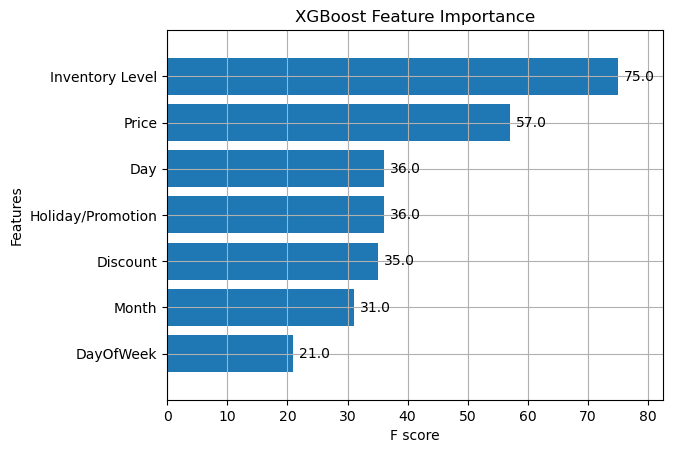

In [107]:

# Plot feature importance
plt.figure(figsize=(12, 8))
xgb.plot_importance(xgb_model, max_num_features=15, height=0.8)
plt.title('XGBoost Feature Importance')
plt.show()


In [108]:
## 7. Make Predictions
y_pred = xgb_model.predict(X_test)


In [109]:

# Preview predictions vs actual
results_df = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred,
    'Error': y_test - y_pred
})
results_df


,Actual,Predicted,Error
Date,,,
2023-08-11,-5.223333,-5.425408,0.202075
2023-08-12,0.014000,-5.069634,5.083634
2023-08-13,-6.338000,-4.784897,-1.553103
2023-08-14,-11.415000,-5.580727,-5.834273
2023-08-15,1.635714,-7.449050,9.084765
...,...,...,...
2023-12-28,-5.563333,-4.924945,-0.638388
2023-12-29,-17.113333,3.247619,-20.360952
2023-12-30,-2.470000,-4.567181,2.097181


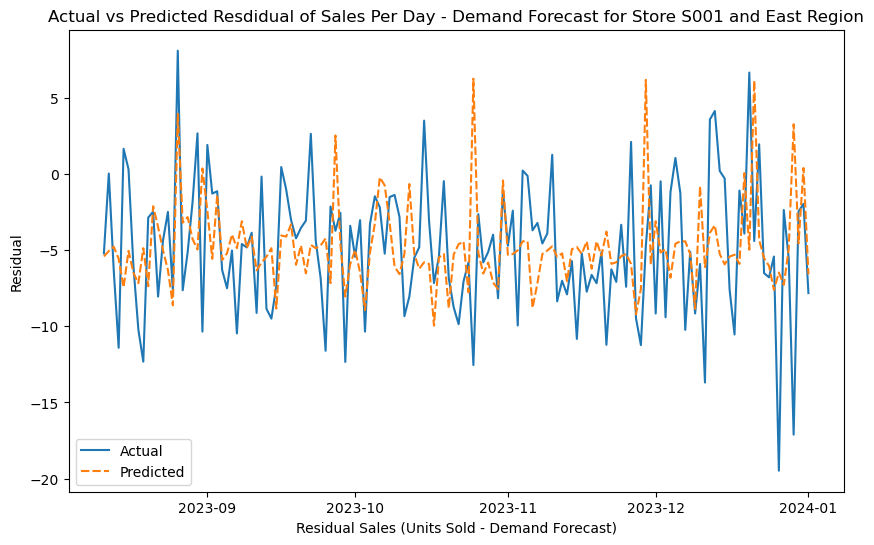

In [110]:
# Plot the Actual vs Predicted
plt.figure(figsize=(10, 6))
sns.lineplot(results_df[['Actual', 'Predicted']])
plt.title('Actual vs Predicted Resdidual of Sales Per Day - Demand Forecast for Store S001 and East Region')
plt.xlabel('Residual Sales (Units Sold - Demand Forecast)')
plt.ylabel('Residual')
plt.show()

In [111]:
# Calculate rmse and f-1 score for final model
# get metrics of model
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# show metrics
metrics_df = pd.DataFrame([rmse, mae, r2], columns=['Metrics'], index=['RMSE','MAE', 'R2']).round(2)

metrics_df

,Metrics
RMSE,4.97
MAE,3.73
R2,-0.29


In [112]:
from sklearn.model_selection import GridSearchCV

# use grid search CV to perform hyper parameter tuning

params = {
    'max_depth': [3, 4, 5, 6, 7, 8, 9],
    'learning_rate': [0.01, 0.03, 0.6, .1],
}

grid_search = GridSearchCV(
    estimator=xgb.XGBRegressor(objective='reg:squarederror', random_state=42),
    param_grid=params,
    scoring='neg_mean_squared_error',
    cv=3, # use 3 fold cross validation
    verbose=1
)





In [113]:
# Perform grid search on two parameters max depth and learning rate and assign to variable best model
best_model = grid_search.fit(X_train, y_train).best_estimator_



Fitting 3 folds for each of 28 candidates, totalling 84 fits


In [114]:
# get predictions
y_pred_best = best_model.predict(X_test)



# Calculate rmse and f-1 score for final best model
# get metrics of model
rmse = np.sqrt(mean_squared_error(y_test, y_pred_best))
mae = mean_absolute_error(y_test, y_pred_best)
r2 = r2_score(y_test, y_pred_best)

# show metrics
metrics_df = pd.DataFrame([rmse, mae, r2], columns=['Metrics'], index=['RMSE','MAE', 'R2']).round(2)

metrics_df


,Metrics
RMSE,4.39
MAE,3.41
R2,-0.00


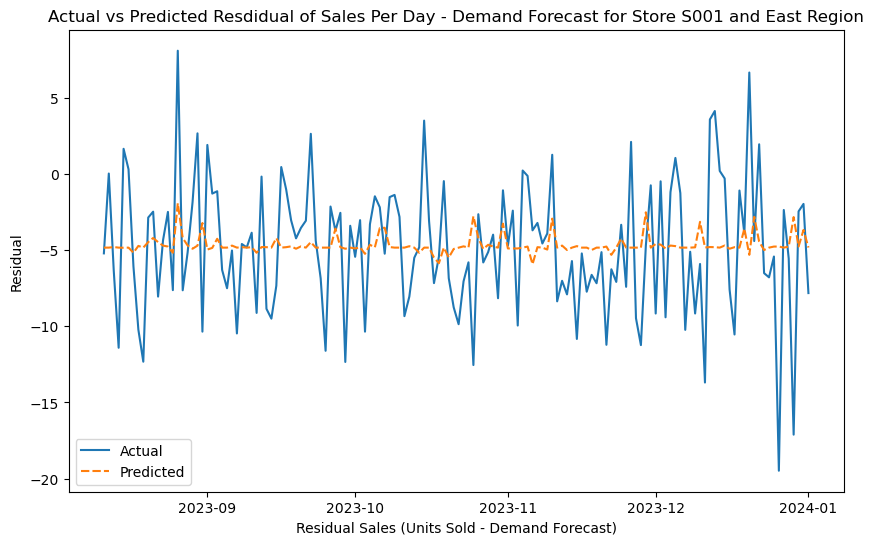

In [115]:
# Preview predictions vs actual for best model
results_best = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred_best
})

# Plot the Actual vs Predicted for best model
plt.figure(figsize=(10, 6))
sns.lineplot(results_best[['Actual', 'Predicted']])
plt.title('Actual vs Predicted Resdidual of Sales Per Day - Demand Forecast for Store S001 and East Region')
plt.xlabel('Residual Sales (Units Sold - Demand Forecast)')
plt.ylabel('Residual')
plt.show()